In [1]:
from PIL import Image
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

!ls

core  Demo.m  imgs  octave-workspace  res.jpg  tsmooth.m  Untitled.ipynb


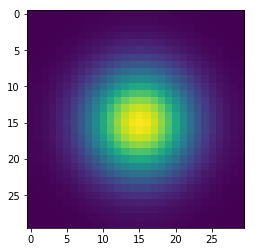

In [2]:
from scipy.ndimage import gaussian_filter

import numpy as np
import scipy.ndimage.filters as fi

def gkern2(kernlen=30, sig=5):
    """Returns a 2D Gaussian kernel array."""

    # create nxn zeros
    inp = np.zeros((kernlen, kernlen))
    # set element at the middle to one, a dirac delta
    inp[kernlen//2, kernlen//2] = 1
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    return fi.gaussian_filter(inp, sig)

plt.imshow(gkern2())

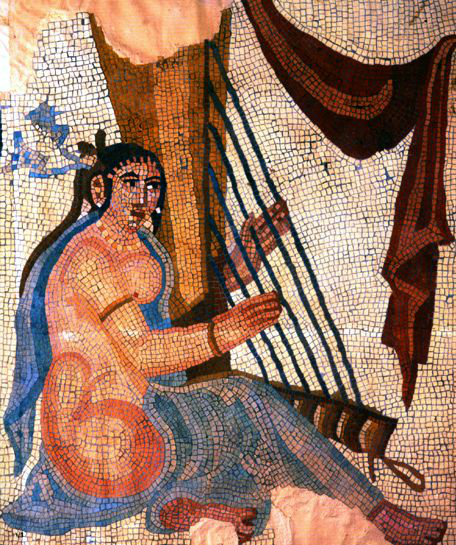

In [3]:
img = Image.open('imgs/Bishapur_zan.jpg')
img

In [5]:
I = torch.tensor(np.array(img)).float()/255
S = torch.randn(I.shape)

I.shape

torch.Size([545, 456, 3])

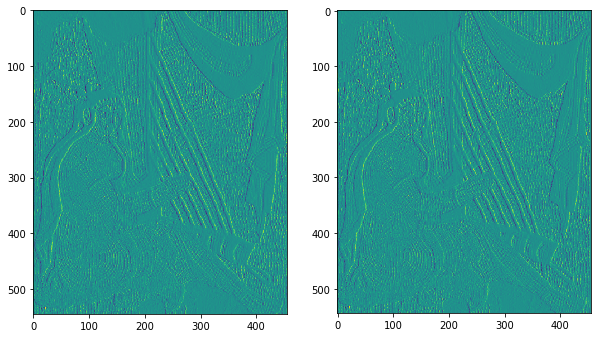

In [6]:
fy = I[1:, :, :] - I[:-1, :, :]
fy = torch.cat([fy, torch.zeros(1, I.shape[1], I.shape[2])], dim=0)

fx = I[:, 1:, :] - I[:, :-1, :]
fy = torch.cat([fx, torch.zeros(I.shape[0], 1, I.shape[2])], dim=1)

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(fx.numpy()[..., 0])
plt.subplot(122)
plt.imshow(fy.numpy()[..., 0])
plt.show()

258670.046875


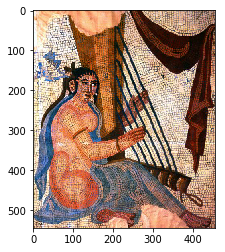

-0.005429703276604414


KeyboardInterrupt: 

In [8]:
I = torch.tensor(np.array(img)).float()/255
S = Variable(I.clone(), requires_grad=True)# .requres_grad(True)


R = 30
sigma = 5
eps = 0.001
lmbd = 0.01

k = torch.FloatTensor(gkern2(R, sigma))

kernel = torch.stack([
    torch.stack([k, torch.zeros_like(k), torch.zeros_like(k)]), 
    torch.stack([torch.zeros_like(k), k, torch.zeros_like(k)]), 
    torch.stack([torch.zeros_like(k), torch.zeros_like(k), k])
])



def eval_loss():

    fy = S[1:, :, :] - S[:-1, :, :]
    fy = torch.cat([fy, torch.zeros(1, I.shape[1], I.shape[2])], dim=0)

    fx = S[:, 1:, :] - S[:, :-1, :]
    fx = torch.cat([fx, torch.zeros(I.shape[0], 1, I.shape[2])], dim=1)
    
    assert fx.shape == fy.shape, f'{fx.shape} != {fy.shape} for I {I.shape}'

    Dx = F.conv2d(fx.abs().permute(2, 0, 1).unsqueeze(0), kernel).squeeze().permute(1, 2, 0)
    Dy = F.conv2d(fy.abs().permute(2, 0, 1).unsqueeze(0), kernel).squeeze().squeeze().permute(1, 2, 0)

    Lx = F.conv2d(fx.permute(2, 0, 1).unsqueeze(0), kernel).abs().squeeze().permute(1, 2, 0)
    Ly = F.conv2d(fy.permute(2, 0, 1).unsqueeze(0), kernel).abs().squeeze().permute(1, 2, 0)
    # print(Lx.shape, Ly.shape, Dx.shape, S.shape, I.shape)
    return ((S - I)**2).sum() + (lmbd * ( Dx / (Lx + eps) + Dy / (Ly + eps) )).sum()


# optimizer = optim.Adam(S.parameters(), lr=0.001)
lr = 0.1
for i in range(100):
    
    loss = eval_loss()
    loss.backward()
    
    if i % 10 == 0:
        print(loss.item())
        plt.imshow(S.data.numpy())
        plt.show()
    
    print(S.grad.data.sum().item())
    avg_grad = np.abs(S.grad.data.cpu().numpy()).mean()
    norm_lr = lr / ( avg_grad + eps)
    S.data += norm_lr * S.grad.data
    S.data = np.clip(S.data, 0, 1)
    S.grad.data.zero_()
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


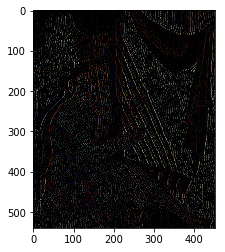

In [76]:
plt.imshow(Dx[0].permute(1, 2, 0).numpy())